## Introducting collision

In [1]:
import numpy as np
import matplotlib.pyplot as plt
W, L = 200, 200 # width and length of the grid
velocity_set = np.array([[0, 0], [0, 1], [1, 0], [0, -1], [-1, 0],
                            [1, 1], [-1, -1], [1, -1], [-1, 1]])

# velocity and density are 2D arrays
#velocity = np.zeros((L, W))
#density = np.zeros((L, W))


def init_pdf(mode = "random_uniform"): # uniform distribution
    pdf = np.ones((len(velocity_set), L, W)) * 0.1 # avoid zero density
    if mode == "random_uniform":
        for i in range(len(velocity_set)):
            pdf[i] += np.random.uniform(0, 1, (L, W))
        pdf /= np.sum(pdf)
    elif mode == "line":
        pdf[:, :, W//2] += 1 / len(velocity_set)
        pdf /= np.sum(pdf)
    elif mode == "circle":
        for i in range(len(velocity_set)):
            for x in range(L):
                for y in range(W):
                    if (x - L//2)**2 + (y - W//2)**2 < 10**2:
                        pdf[i, x, y] += 1
        pdf /= np.sum(pdf)
    elif mode == "square":
        for i in range(len(velocity_set)):
            for x in range(L):
                for y in range(W):
                    if abs(x - L//2) < 10 and abs(y - W//2) < 10:
                        pdf[i, x, y] += 1
        pdf /= np.sum(pdf)
    else:
        raise ValueError("Invalid mode")
    return pdf


In [2]:
def calc_density(pdf):
    density = np.sum(pdf, axis=0)
    return density

def calc_velocity(pdf):
    velocity = np.zeros((L, W, 2))
    # loop through all positions
    for i in range(L):
        for j in range(W):
            # loop through all velocities
            for k in range(len(velocity_set)):
                velocity[i, j, 0] += pdf[k, i, j] * velocity_set[k, 0]
                velocity[i, j, 1] += pdf[k, i, j] * velocity_set[k, 1]
            velocity[i, j, 0] /= calc_density(pdf)[i, j]
            velocity[i, j, 1] /= calc_density(pdf)[i, j]
    return velocity


def calc_local_avg_velocity(pdf):
    density = calc_density(pdf)
    sum = np.zeros((L, W, 2))
    for i in range(len(velocity_set)):
        sum[:, :, 0] += velocity_set[i, 0, None]*pdf[i, :, :]
        sum[:, :, 1] += velocity_set[i, 1, None]*pdf[i, :, :]
    return sum / density[:, :, None] 

def calc_equilibrium_pdf(density, velocity):
    w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
    equilibrium_pdf = np.zeros((len(velocity_set), L, W))
    for i in range(len(velocity_set)):
        equilibrium_pdf[i] = w[i]*density*\
            (1 + 
             3*(velocity_set[i, 0]*velocity[:, :, 0] + velocity_set[i, 1]*velocity[:, :, 1]) +
             9/2*(velocity_set[i, 0]*velocity[:, :, 0] + velocity_set[i, 1]*velocity[:, :, 1])**2 - 
             3/2*(velocity[:, :, 0]**2 + velocity[:, :, 1]**2))
    return equilibrium_pdf


In [3]:
def streaming(pdf):
    """ Streaming step """
    pdf_t1 = np.zeros_like(pdf)
    # use np.roll to shift the pdf
    for i in range(len(velocity_set)):
        pdf_t1[i] = np.roll(pdf[i], velocity_set[i, 0], axis=0)
        pdf_t1[i] = np.roll(pdf_t1[i], velocity_set[i, 1], axis=1)
    return pdf_t1

In [4]:
# visualize the pdf
def plot_pdf(pdf):
    plt.figure()
    plt.imshow(calc_density(pdf))
    plt.show()

def plot_velocity(pdf):
    plt.figure()
    velocity = calc_velocity(pdf)
    print(velocity.shape)
    plt.streamplot(np.arange(W), np.arange(L), velocity[:, :, 0], velocity[:, :, 1])
    plt.show()
    

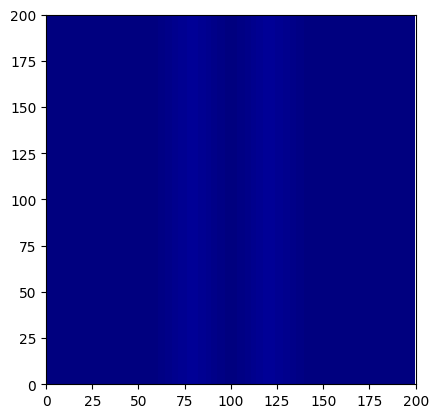

In [5]:
# display an animation of the pdf using the animation module of matplotlib
from matplotlib import animation
from IPython.display import HTML

pdf = init_pdf(mode="line")

fig = plt.figure()
ax = plt.axes(xlim=(0, W), ylim=(0, L))
im = ax.imshow(calc_density(pdf), cmap='jet')

def animate(i):
    #print(i)
    global pdf
    omega = 1
    pdf_streamed = streaming(pdf)

    #assert np.allclose(np.sum(pdf), np.sum(pdf_streamed)) # check mass conservation

    
    # recalculate the density
    density = calc_density(pdf_streamed)
    """
    print("density = ", density)
    print("density shape = ", density.shape)
    """
    # calculate local average velocity
    local_avg_velocity = calc_local_avg_velocity(pdf_streamed)
    """
    print("local_avg_velocity = ", local_avg_velocity)
    print("local_avg_velocity shape = ", local_avg_velocity.shape)
    """
    # calculate equilibrium pdf
    equilibrium_pdf = calc_equilibrium_pdf(density, local_avg_velocity)
    """
    print("equilibrium_pdf = ", equilibrium_pdf)
    print("equilibrium_pdf shape = ", equilibrium_pdf.shape)
    """
    
    # collision step using np.roll
    pdf_collision = pdf_streamed + omega*(equilibrium_pdf - pdf_streamed)
    """
    print("pdf_collision = ", pdf_collision)
    print("pdf_collision shape = ", pdf_collision.shape)
    """

    """
    pdf_collision = np.zeros_like(pdf_streamed)

    for i in range(len(velocity_set)):
        pdf_collision[i] = np.roll(pdf_streamed[i] + omega*(equilibrium_pdf[i] - pdf_streamed[i]), velocity_set[i, 0], axis=0)
        pdf_collision[i] = np.roll(pdf_streamed[i] + omega*(equilibrium_pdf[i] - pdf_streamed[i]), velocity_set[i, 1], axis=0)
    """

    #assert np.allclose(np.sum(pdf_streamed), np.sum(pdf_collision)) # check mass conservation

    pdf = pdf_collision
    # update the image
    im.set_array(calc_density(pdf))
    return im,

anim = animation.FuncAnimation(fig, animate, frames=300, interval=200, blit=True)
HTML(anim.to_html5_video())


In [10]:
# array of size 100 where each element is its own index
# np.arange(100)
L = 10
incr_array = np.tile(np.arange(L), (L, 1)) #
print(incr_array.T)


[[0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2]
 [3 3 3 3 3 3 3 3 3 3]
 [4 4 4 4 4 4 4 4 4 4]
 [5 5 5 5 5 5 5 5 5 5]
 [6 6 6 6 6 6 6 6 6 6]
 [7 7 7 7 7 7 7 7 7 7]
 [8 8 8 8 8 8 8 8 8 8]
 [9 9 9 9 9 9 9 9 9 9]]
